### Importing relevant packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas_profiling import ProfileReport
from pycaret.classification import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix




### Reading data

In [3]:
df_rain_aus = pd.read_csv('./data/rain_data_aus.csv')
df_wt = pd.read_csv('./data/wind_table_01.csv')

In [4]:
df_rain_aus['date'] = pd.to_datetime(df_rain_aus['date'], format='%Y-%M-%d')

### Spring to get first model

In [5]:
df_rain_aus = pd.read_csv('./data/rain_data_aus.csv')

winds_filenames = [f'./data/wind_table_0{i}.csv' for i in range(2,9)]

df_winds = pd.read_csv('./data/wind_table_01.csv')
for wind in winds_filenames:
    df_append = pd.read_csv(wind)
    zipy = {x: y for x, y in zip(df_winds.columns, df_append.columns)}
    df_winds = df_winds.append(df_append.rename(columns=zipy))
    
df_winds.drop(columns=['windgustdir', 'windgustspeed', 'winddir9am', 
                       'winddir3pm', 'windspeed9am', 'windspeed3pm'], inplace=True)

In [6]:
df_rain_aus['date'] = pd.to_datetime(df_rain_aus['date'], format='%Y-%m-%d')
df_winds['date'] = pd.to_datetime(df_winds['date'], format='%Y-%m-%d')

In [7]:
def season(x):
    if x.month < 3 or x.month==12:
        return 'summer'
    if x.month >=3 and x.month < 6:
        return 'autumn'
    if x.month >=6 and x.month < 9:
        return 'winter'
    if x.month >=9 and x.month < 12:
        return 'spring'

In [8]:
df_merged = pd.merge(left=df_rain_aus,
                    right = df_winds,
                    on = ['date', 'location'])

In [9]:
df_merged['amountOfRain'].dropna(inplace=True)
df_merged.drop(columns=['modelo_vigente'], inplace=True)

In [10]:
# ProfileReport(df=df_merged).to_file('pandas_profiling.html')

In [11]:
drop_cols = ['pressure9am', 'temp9am', 'cloud9am', 'precipitation9am',
             'wind_speed9am', 'humidity9am']
df_merged.drop(columns = drop_cols, inplace=True)
# ', 'windspeed9am'

In [12]:
df_merged.columns

Index(['date', 'location', 'mintemp', 'maxtemp', 'rainfall', 'evaporation', 'sunshine', 'humidity3pm', 'pressure3pm', 'cloud3pm', 'temp3pm', 'raintoday', 'amountOfRain', 'raintomorrow', 'temp', 'humidity', 'precipitation3pm', 'wind_gustdir', 'wind_gustspeed', 'wind_dir9am', 'wind_dir3pm', 'wind_speed3pm'], dtype='object')

In [13]:
df_merged['amp_temp'] = df_merged['mintemp'] /  df_merged['maxtemp']
df_merged['change_wind'] = np.where(df_merged['wind_dir9am'] != df_merged['wind_dir3pm'],1,0)



df_merged.drop(columns = ['mintemp', 'maxtemp', 'temp', 'humidity3pm'
                          ,'wind_dir9am','wind_dir3pm'], inplace=True)


In [14]:
df_merged['season'] = df_merged['date'].apply(season)
# df_merged = pd.concat([df_merged,pd.get_dummies(data=df_merged, drop_first=True, 
#                                     columns=['location', 'raintoday', 'season'])], axis=1)
# df_merged.drop(columns=['location', 'raintoday', 'amountOfRain','date', 'season'], inplace=True)

In [15]:
df_merged['raintomorrow'] = df_merged['raintomorrow'].replace({'No': 0, 'Yes': 1})    

In [16]:
df_merged.drop(columns=['date', 'amountOfRain'], inplace=True)

In [17]:
df_merged = df_merged[df_merged['location'] == 'Cairns']

In [18]:
df_merged.shape

(3402, 17)

In [19]:
py_carat = setup(data = df_merged, 
                 target = 'raintomorrow', 
                 session_id=42,
                ignore_low_variance=True,
                normalize=True,
                remove_multicollinearity=True,
                n_jobs=obs=-1)

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(3402, 17)"
4,Missing Values,True
5,Numeric Features,11
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [20]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.8223,0.8790,0.6493,0.7643,0.7008,0.5758,0.5807,0.3173
1,Extra Trees Classifier,0.8190,0.8924,0.6479,0.7546,0.6955,0.5681,0.5726,0.3495
2,Random Forest Classifier,0.8186,0.8744,0.6269,0.7675,0.6885,0.5626,0.5694,0.0748
3,Gradient Boosting Classifier,0.8139,0.8664,0.6074,0.7641,0.6755,0.5479,0.5557,0.7096
4,CatBoost Classifier,0.8114,0.8794,0.6165,0.7518,0.6766,0.5455,0.5515,6.0314
5,Extreme Gradient Boosting,0.8076,0.8722,0.6518,0.7247,0.6848,0.5472,0.5499,0.5426
6,Ada Boost Classifier,0.7967,0.8564,0.6061,0.7180,0.6562,0.5136,0.5180,0.2684
7,Ridge Classifier,0.7934,0.0000,0.5839,0.7203,0.6432,0.5004,0.5070,0.1039
8,Linear Discriminant Analysis,0.7929,0.8484,0.6008,0.7101,0.6497,0.5045,0.5088,0.0362
9,Logistic Regression,0.7917,0.8519,0.5892,0.7130,0.6432,0.4985,0.5042,0.2666


In [21]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8159,0.9016,0.6104,0.7705,0.6812,0.5542,0.5616
1,0.8445,0.8792,0.6753,0.8125,0.7376,0.6285,0.6339
2,0.7773,0.8360,0.5844,0.6818,0.6294,0.4716,0.4744
3,0.8025,0.8620,0.6623,0.7083,0.6846,0.5411,0.5417
4,0.8529,0.9188,0.7500,0.7808,0.7651,0.6581,0.6584
5,0.7899,0.8484,0.5789,0.7097,0.6377,0.4919,0.4969
6,0.8403,0.8877,0.6316,0.8276,0.7164,0.6081,0.6188
7,0.8529,0.9166,0.6842,0.8254,0.7482,0.6456,0.6513
8,0.8151,0.8830,0.6974,0.7162,0.7067,0.5717,0.5718
9,0.8319,0.8570,0.6184,0.8103,0.7015,0.5875,0.5978


In [23]:
tuned_lgbm = tune_model(estimator=lgbm, fold=10, n_iter=100, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8368,0.8822,0.6753,0.7879,0.7273,0.6118,0.6155
1,0.8109,0.8666,0.6623,0.7286,0.6939,0.5575,0.5589
2,0.7941,0.8404,0.6364,0.7000,0.6667,0.5182,0.5195
3,0.7773,0.8385,0.6753,0.6500,0.6624,0.4964,0.4966
4,0.8571,0.9248,0.7368,0.8000,0.7671,0.6643,0.6655
5,0.7689,0.8320,0.5921,0.6522,0.6207,0.4551,0.4562
6,0.7899,0.8681,0.6316,0.6857,0.6575,0.5064,0.5073
7,0.8613,0.9104,0.7500,0.8028,0.7755,0.6754,0.6762
8,0.8277,0.8759,0.7368,0.7273,0.7320,0.6051,0.6051
9,0.8277,0.8683,0.6579,0.7692,0.7092,0.5879,0.5915


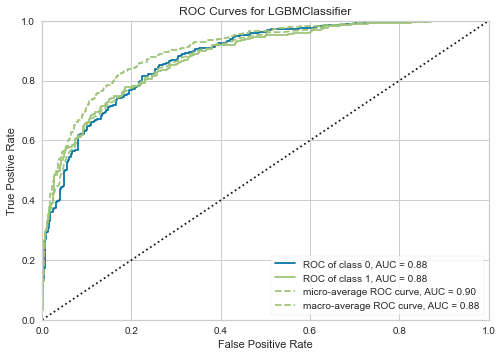

In [24]:
plot_model(lgbm, plot = 'auc')

In [25]:
predict_model(tuned_lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8031,0.874,0.6646,0.7055,0.6845,0.5416,0.5421


,rainfall,evaporation,sunshine,pressure3pm,temp3pm,humidity,precipitation3pm,amp_temp,cloud3pm_0.0,cloud3pm_1.0,...,wind_gustdir_WNW,wind_gustdir_WSW,wind_gustdir_not_available,season_autumn,season_spring,season_summer,season_winter,raintomorrow,Label,Score
0,-0.319216,-6.268373e-02,9.920140e-01,0.963311,-1.026006,-0.799869,0.621742,-1.489133,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.0000
1,-0.150188,-6.268373e-02,2.703975e-01,0.840950,-1.182148,0.278925,0.938194,0.489245,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,0.2702
2,-0.195262,-6.268373e-02,7.296080e-01,-0.798681,1.081909,0.938188,0.938194,1.023764,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,0.5267
3,-0.319216,2.854727e-16,2.913292e-16,0.180203,-0.011084,-0.680003,-0.011162,-1.923442,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0,0.0000
4,1.540084,-5.769457e-01,-7.792264e-01,-1.361540,1.159980,0.218992,-0.011162,-0.346380,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0,0.0199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,-0.319216,2.854727e-16,2.913292e-16,1.012255,-0.674687,0.458724,-0.011162,0.646347,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0,0.0124
1017,-0.319216,1.599016e-03,8.608110e-01,-0.358183,0.847696,0.099126,1.571099,0.201644,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0,0.0020
1018,0.097718,2.854727e-16,2.913292e-16,-0.896570,1.394193,0.039193,-0.011162,0.497727,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,1,0.9813
1019,-0.319216,3.872955e-01,1.320021e+00,-0.847626,0.691554,-0.200539,0.938194,-0.971914,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0,0.0001


In [26]:
evaluate_model(tuned_lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.7, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0,
               n_estimators=170, n_jobs=-1, num_leaves=60, objective=None,
               random_state=42, reg_alpha=0.1, reg_lambda=0.8, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0), plot=summary, feature=None, observation=None)
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:plot type: summary
INFO:logs:model type detected: type 1
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values


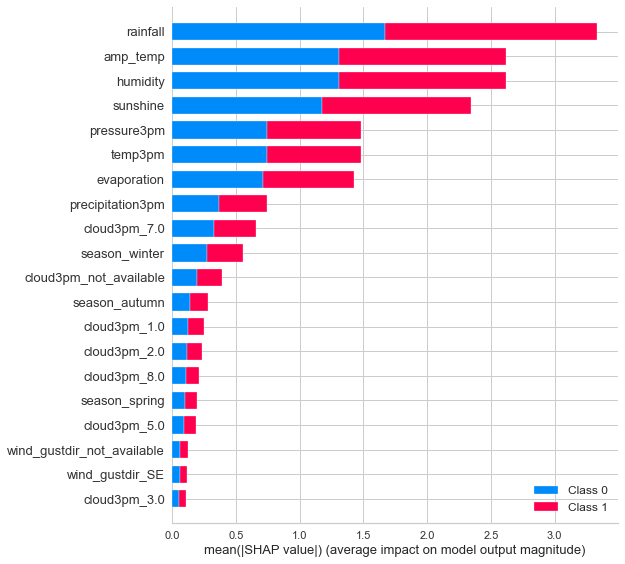

INFO:logs:Visual Rendered Successfully
INFO:logs:interpret_model() succesfully completed......................................


In [29]:
interpret_model(tuned_lgbm)